(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:02:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9992598597257957
Precision: 0.8117647058823529
Recall: 0.7263157894736842
F1 Score: 0.7666666666666667
ROC AUC: 0.9340260635525549


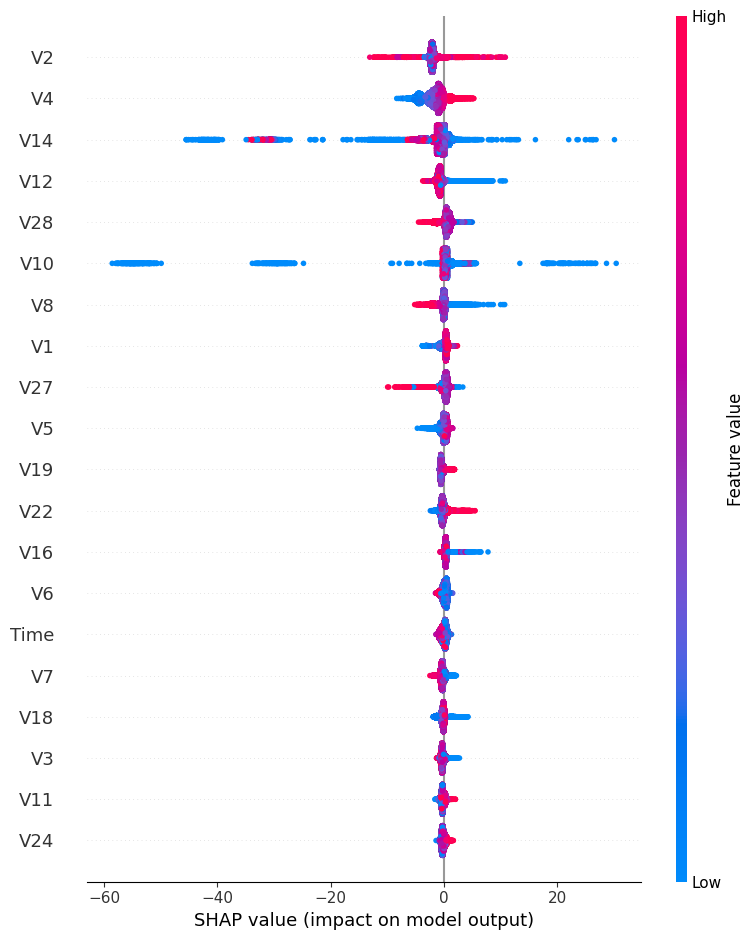

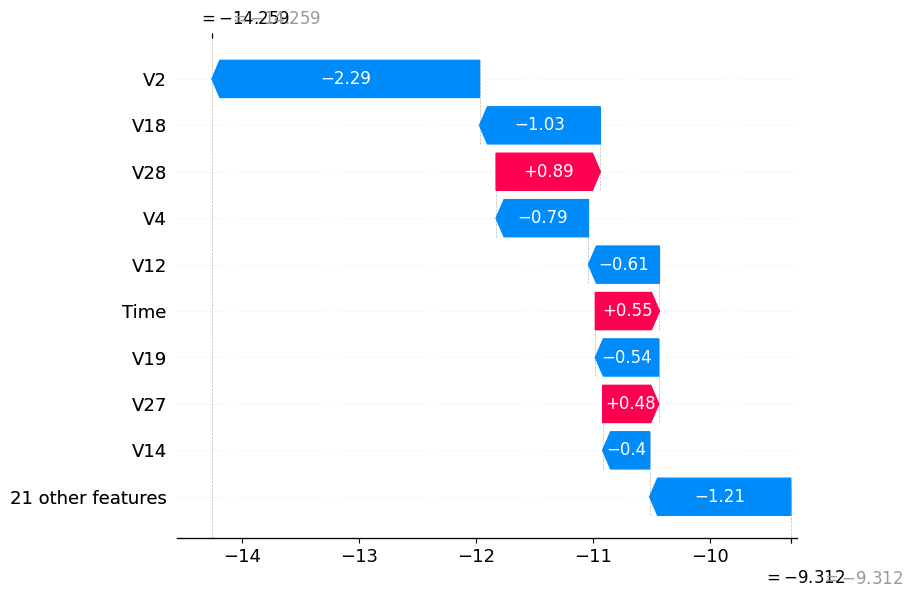

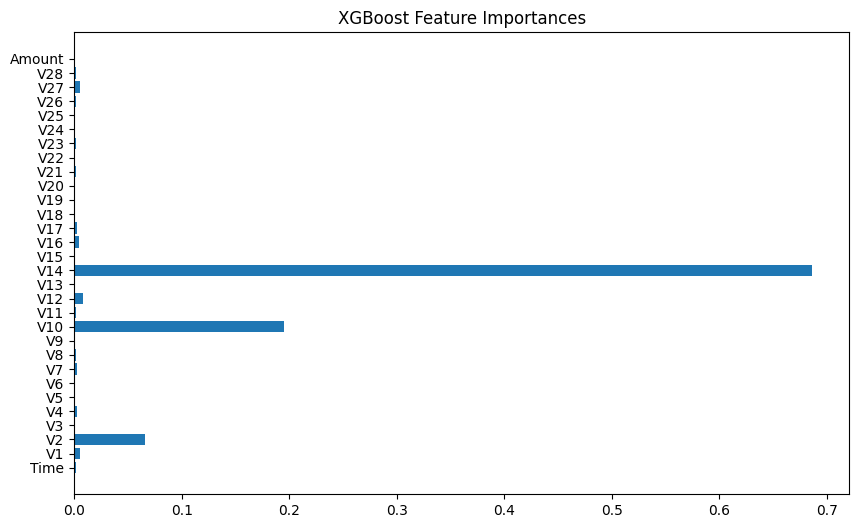

Top 5 features by SHAP:
V2: 1.9635
V4: 1.8360
V14: 1.3115
V12: 0.7988
V28: 0.7351


In [1]:
!pip install shap
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df = pd.read_csv(url)

print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())

print(f"Duplicates: {df.duplicated().sum()}")

df = df.drop_duplicates()


X = df.drop('Class', axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=df.columns[:-1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:], feature_names=df.columns[:-1])

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0,:], feature_names=df.columns[:-1])

importances = model.feature_importances_
feature_names = df.columns[:-1]

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.title('XGBoost Feature Importances')
plt.show()

shap_importance = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_importance)[-5:][::-1]
print("Top 5 features by SHAP:")
for i in top_indices:
    print(f"{feature_names[i]}: {shap_importance[i]:.4f}")
